In [13]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Attention

In [17]:
def process_subject(subject_path, win=7000, stride=3500):
    with open(os.path.join(subject_path, f"{os.path.basename(subject_path)}.pkl"), "rb") as f:
        data = pickle.load(f, encoding='latin1')

    chest = data["signal"]["chest"]
    labels = data["label"]

    if isinstance(chest, dict):
        ecg = chest["ECG"]
        acc = chest["ACC"]
    else:
        ecg = chest[:, 0]
        acc = chest[:, 5:8]

    ecg_out, acc_out, y_out = [], [], []
    for i in range(0, len(labels) - win, stride):
        l = labels[i:i+win]
        if np.all(l == 2):
            label = 1
        elif np.all(np.isin(l, [1, 3])):
            label = 0
        else:
            continue
        ecg_out.append(ecg[i:i+win])
        acc_out.append(acc[i:i+win])
        y_out.append(label)

    return np.array(ecg_out), np.array(acc_out), np.array(y_out)


In [21]:
# Excluding excluding S1 and S12 as mentioned in the dataset README

subject_ids = [f"S{i}" for i in range(2, 18) if i not in [12]]
base_path = "./"

# Load all subjects
X_ecg_all, X_acc_all, y_all = [], [], []

for sid in subject_ids:
    folder = os.path.join(base_path, sid)
    if not os.path.exists(os.path.join(folder, f"{sid}.pkl")):
        print(f"Skipping {sid}, file not found.")
        continue
    print(f"Processing {sid}")
    X_ecg, X_acc, y = process_subject(folder)
    X_ecg_all.append(X_ecg)
    X_acc_all.append(X_acc)
    y_all.append(y)

# combine all of the data
X_ecg_all = np.concatenate(X_ecg_all)
X_acc_all = np.concatenate(X_acc_all)
y_all = np.concatenate(y_all)

# Normalize
X_ecg_all = (X_ecg_all - np.mean(X_ecg_all)) / np.std(X_ecg_all)
X_acc_all = (X_acc_all - np.mean(X_acc_all)) / np.std(X_acc_all)

# Train/test split
X_ecg_train, X_ecg_test, X_acc_train, X_acc_test, y_train, y_test = train_test_split(
    X_ecg_all, X_acc_all, y_all, test_size=0.2, random_state=42
)


def build_model(ecg_shape, acc_shape):
    """Builds the stress detection model."""

    ecg_input = tf.keras.Input(shape=ecg_shape, name="ecg_input")
    x1 = tf.keras.layers.Reshape((ecg_shape[0], 1))(ecg_input)
    x1 = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', name="ecg_conv1")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="ecg_bn1")(x1)
    x1 = tf.keras.layers.MaxPooling1D(2, name="ecg_pool1")(x1)
    x1 = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same', name="ecg_conv2")(x1)
    x1 = tf.keras.layers.BatchNormalization(name="ecg_bn2")(x1)
    x1 = tf.keras.layers.LSTM(32, return_sequences=True, name="ecg_lstm1")(x1)
    
    # using attention layers
    x1_attention = Attention(name="ecg_attention")([x1, x1])
    
    x1 = tf.keras.layers.LSTM(32, name="ecg_lstm2")(x1_attention)

    acc_input = tf.keras.Input(shape=acc_shape, name="acc_input")
    x2 = tf.keras.layers.Conv1D(16, 5, activation='relu', padding='same', name="acc_conv1")(acc_input)
    x2 = tf.keras.layers.BatchNormalization(name="acc_bn1")(x2)
    x2 = tf.keras.layers.MaxPooling1D(2, name="acc_pool1")(x2)
    x2 = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same', name="acc_conv2")(x2)
    x2 = tf.keras.layers.BatchNormalization(name="acc_bn2")(x2)
    x2 = tf.keras.layers.LSTM(32, return_sequences=True, name="acc_lstm1")(x2)
    
    x2_attention = Attention(name="acc_attention")([x2, x2])
    
    x2 = tf.keras.layers.LSTM(32, name="acc_lstm2")(x2_attention)

    concatenated = tf.keras.layers.concatenate([x1, x2], name="concatenate")
    dense1 = tf.keras.layers.Dense(64, activation='relu', name="dense1")(concatenated)
    dropout = tf.keras.layers.Dropout(0.3, name="dropout")(dense1)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout)

    model = tf.keras.Model(inputs=[ecg_input, acc_input], outputs=output, name="stress_detection_model")
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(curve='PR', name='auprc')],
                  weighted_metrics=['accuracy', tf.keras.metrics.AUC(name='weighted_auc'), tf.keras.metrics.AUC(curve='PR', name='weighted_auprc')])
    return model

# Training the mdoel
model = build_model(X_ecg_train.shape[1:], X_acc_train.shape[1:])
history = model.fit([X_ecg_train, X_acc_train], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluating model
y_pred = model.predict([X_ecg_test, X_acc_test])

# finding the best threshold
# for i in range(1,11):
#     y_pred_bin = (y_pred > i/10).astype(int)
#     print(classification_report(y_test, y_pred_bin))
#     print("AUC-ROC:", roc_auc_score(y_test, y_pred))
#     plot_training(history)
#     plot_confusion(y_test, y_pred_bin)
#     plot_roc(y_test, y_pred)

y_pred_bin = (y_pred > 0.3).astype(int)

print(classification_report(y_test, y_pred_bin))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))


Processing S2
Processing S3
Processing S4
Processing S5
Processing S6
Processing S7
Processing S8
Processing S9
Processing S10
Processing S11
Processing S13
Processing S14
Processing S15
Processing S16
Processing S17
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 2206s 17s/step - accuracy: 0.7234 - auc: 0.7254 - auprc: 0.4946 - loss: 0.5356 - weighted_accuracy: 0.7234 - weighted_auc: 0.7254 - weighted_auprc: 0.4946 - val_accuracy: 0.7287 - val_auc: 0.7770 - val_auprc: 0.6352 - val_loss: 0.5724 - val_weighted_accuracy: 0.7287 - val_weighted_auc: 0.7770 - val_weighted_auprc: 0.6352
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 7315s 55s/step - accuracy: 0.8398 - auc: 0.8968 - auprc: 0.7962 - loss: 0.3634 - weighted_accuracy: 0.8398 - weighted_auc: 0.8968 - weighted_auprc: 0.7962 - val_accuracy: 0.4651 - val_auc: 0.7433 - val_auprc: 0.5484 - val_loss: 1.2538 - val_weighted_accuracy: 0.4651 - val_weighted_auc: 0.7433 - val_weighted_auprc: 0.5484
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 7721s 54s/step - 

In [66]:
# finding the best threshold
# for i in range(1,11):
#     y_pred_bin = (y_pred > i/10).astype(int)
#     print(classification_report(y_test, y_pred_bin))
#     print("AUC-ROC:", roc_auc_score(y_test, y_pred))
#     plot_training(history)
#     plot_confusion(y_test, y_pred_bin)
#     plot_roc(y_test, y_pred)

y_pred_bin = (y_pred > 0.4).astype(int)

print(classification_report(y_test, y_pred_bin))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.83      0.89       915
           1       0.69      0.93      0.79       393

    accuracy                           0.86      1308
   macro avg       0.83      0.88      0.84      1308
weighted avg       0.88      0.86      0.86      1308

AUC-ROC: 0.9648243162446641


In [67]:
def plot_training(history):
    metrics = history.history
    auc_key = 'auc' if 'auc' in metrics else 'AUC' if 'AUC' in metrics else None

    plt.figure(figsize=(10, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(metrics['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(metrics['val_accuracy'], label='Val Accuracy', linestyle='--', linewidth=2)
    plt.title("Model Accuracy", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # AUC
    plt.subplot(1, 2, 2)
    if auc_key:
        plt.plot(metrics[auc_key], label='Train AUC', linewidth=2)
        plt.plot(metrics[f'val_{auc_key}'], label='Val AUC', linestyle='--', linewidth=2)
        plt.title("Model AUC", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
    else:
        plt.title("AUC not available in history")

    plt.tight_layout()
    plt.show()


In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(y_true, y_pred_binary):
    cm = confusion_matrix(y_true, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Stress", "Stress"])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap='Purples', ax=ax, colorbar=False)
    plt.title("Confusion Matrix", fontsize=14)
    plt.grid(False)
    plt.savefig("confusion_matrix_black.png", dpi=300, facecolor='black')
    plt.show()


In [69]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='deepskyblue', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve", fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.savefig("roc_curve_black.png", dpi=300, facecolor='black')
    plt.show()


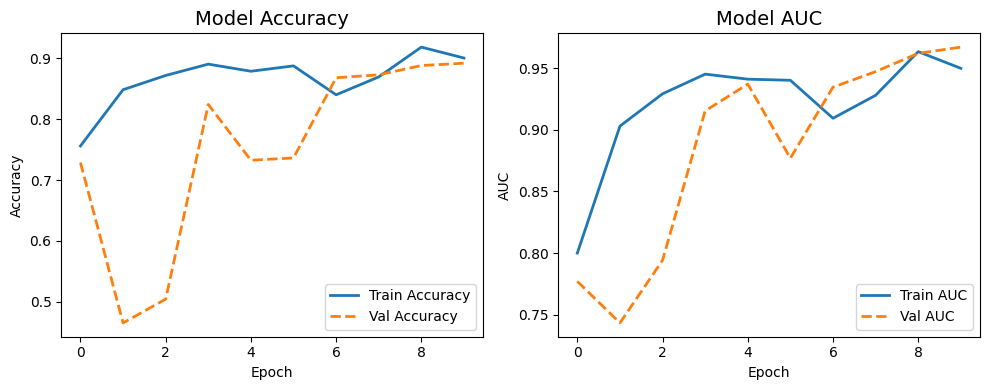

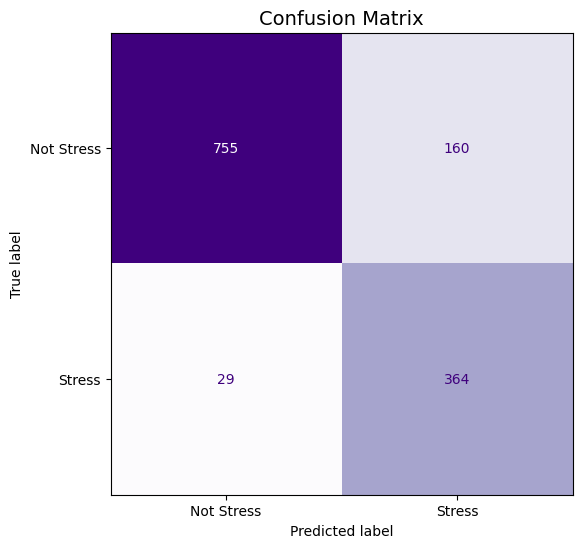

/var/folders/cw/_f9cn_6x41q2s5rsch700m200000gn/T/ipykernel_81368/1731440461.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='gray')


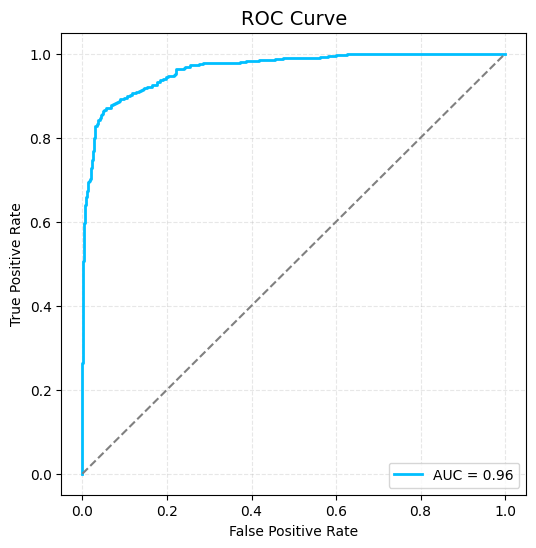

In [70]:
plot_training(history)
plot_confusion(y_test, y_pred_bin)
plot_roc(y_test, y_pred)